<a href="https://colab.research.google.com/github/tatendatobaiwa/cnnmodel2/blob/main/cnnmodel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***SIMPLE CNN MODEL BUILD FOR LUNG CANCER IMAGING***

**Step 1: Mount Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 2: Create Directories in Drive**

**Step 3: Install Dependenices**

In [1]:
import tensorflow as tf
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

project_path = '/content/drive/MyDrive/cnnprojectfinal'
sys.path.append(project_path)

**Mini Step 3a: Verify Fixes**

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Addons version: {tfa.__version__}")

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow version: 2.13.0
TensorFlow Addons version: 0.23.0


**Step 4: Use a script to Load and Preprocess Data**

In [2]:
import cv2
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class DataProcessor:
    def __init__(self, base_path="/content/drive/MyDrive/cnnprojectfinal"):
        self.base_path = Path(base_path)
        self.train_path = self.base_path / "data/raw/train"
        self.test_path = self.base_path / "data/raw/test"

    def load_images(self, directory, target_size=(256, 256), use_clahe=False):
        images = []
        labels = []
        class_names = ['benign', 'malignant', 'normal']
        for label, class_name in enumerate(class_names):
            class_dir = directory / class_name
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in ('.png', '.jpg', '.jpeg'):
                    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Warning: Unable to load image {img_path}")
                        continue
                    if use_clahe:
                        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                        img = clahe.apply(img)
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(label)
        return np.array(images), np.array(labels)

    def create_generators(self, batch_size=32, use_clahe=False):
        # Load images and normalize to [0, 1]
        X_train, y_train = self.load_images(self.train_path, use_clahe=use_clahe)
        X_train = X_train[..., np.newaxis] / 255.0

        # Split into training and validation sets (stratified)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
        )

        # Data augmentation for training
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[1.0, 1.5],
            fill_mode='nearest'
        )
        val_datagen = ImageDataGenerator()  # No augmentation for validation

        train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
        val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)
        return train_generator, val_generator, X_val, y_val

    def show_augmented_images(self, generator, n_images=5, gamma=1.0):
        """
        Visualizes a few augmented images.
        - gamma: a factor for gamma correction (set gamma < 1 to brighten).
        """
        images, labels = next(generator)
        plt.figure(figsize=(15, 3))
        for i in range(n_images):
            img = images[i].squeeze()
            if gamma != 1.0:
                img = np.power(img, 1.0/gamma)
            plt.subplot(1, n_images, i+1)
            plt.imshow(img, cmap='gray', vmin=0, vmax=1)
            plt.title(f"Label: {labels[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

**Step 5: Model Training**

Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 1.3450 - accuracy: 0.5120
Epoch 1: val_loss improved from inf to 1.91855, saving model to best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 102s 4s/step - loss: 1.3450 - accuracy: 0.5120 - val_loss: 1.9186 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.6465
Epoch 2: val_loss improved from 1.91855 to 1.80576, saving model to best_model.h5
28/28 [==============================] - 86s 3s/step - loss: 0.9770 - accuracy: 0.6465 - val_loss: 1.8058 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 0.8549 - accuracy: 0.6682
Epoch 3: val_loss did not improve from 1.80576
28/28 [==============================] - 80s 3s/step - loss: 0.8549 - accuracy: 0.6682 - val_loss: 2.3130 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - ETA: 0s - loss: 0.8402 - accuracy: 0.6807
Epoch 4: val_loss did not improve from 1.80576
28/28 [==============================] - 83s 3s/step - loss: 0.8402 - accuracy: 0.6807 - val_loss: 2.4162 - val_acc

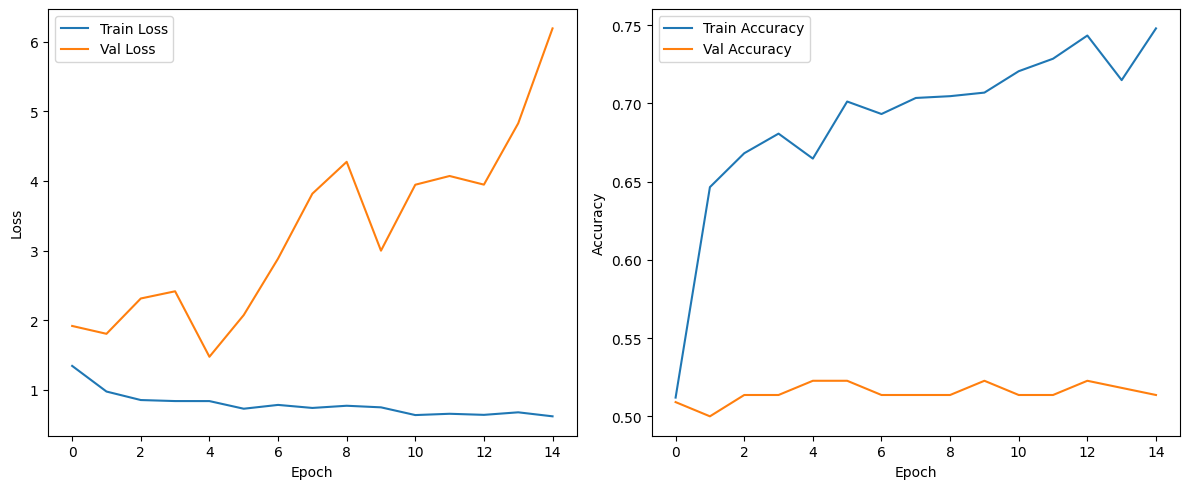

Model saved as /content/drive/MyDrive/cnnprojectfinal/models/final_model.h5


In [12]:
import sys
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Set project root path
project_path = '/content/drive/MyDrive/cnnprojectfinal'
if project_path not in sys.path:
    sys.path.append(project_path)

# Import the DataProcessor from the utils directory
from utils.data_processing import DataProcessor

# Define the transfer-learning model using MobileNetV2
def create_model_transfer(input_shape=(256, 256, 1), num_classes=3):
    """
    Creates a transfer-learning model based on MobileNetV2.

    For grayscale images, the single channel is duplicated to form a 3-channel input.
    """
    # Input layer for grayscale image; convert to 3 channels
    input_layer = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Concatenate()([input_layer, input_layer, input_layer])

    # Load MobileNetV2 with pre-trained ImageNet weights, excluding the top classification layers
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(256, 256, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze the base model so its weights aren't updated

    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define training and plotting functions
def train_model(model, train_generator, val_generator, epochs=50, checkpoint_path='best_model.h5'):
    """
    Trains the model with callbacks for early stopping, checkpointing, and learning rate reduction.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    callbacks = [early_stop, checkpoint, reduce_lr]

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over epochs.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Initialize the data processor and create data generators
    processor = DataProcessor()
    train_gen, val_gen, X_val, y_val = processor.create_generators(batch_size=32)

    # Create the MobileNetV2-based transfer learning model
    model = create_model_transfer(input_shape=(256, 256, 1), num_classes=3)

    # Train the model
    history = train_model(model, train_gen, val_gen, epochs=50, checkpoint_path='best_model.h5')

    # Plot the training history
    plot_training_history(history)

    # Save the final model in the current directory (or specify a desired path)
    final_model_path = '/content/drive/MyDrive/cnnprojectfinal/models/final_model.h5'
    model.save(final_model_path)
    print(f"Model saved as {final_model_path}")


**Step 6b: Coninuation of training the final model**

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from utils.data_processing import DataProcessor
from utils.model_transfer import create_model_transfer  # Your MobileNetV2 model function

# Set model path
model_path = "/content/drive/MyDrive/cnnprojectfinal/models/final_model.h5"

# Initialize the data processor and generators
processor = DataProcessor()
train_gen, val_gen, _, _ = processor.create_generators(batch_size=32)

# Check if a trained model exists and load it
if os.path.exists(model_path):
    print("🔄 Loading existing trained model...")
    model = tf.keras.models.load_model(model_path)
else:
    print("🚀 No existing model found. Creating a new one...")
    model = create_model_transfer(input_shape=(256, 256, 1), num_classes=3)

# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
callbacks = [early_stop, checkpoint, reduce_lr]

# Train the model (continue training from the existing one)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # Continue training with additional epochs
    callbacks=callbacks,
    verbose=1
)

# Save the updated model again
model.save(model_path)
print("✅ Model training complete and saved.")


🔄 Loading existing trained model...
Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 0.8558 - accuracy: 0.6682
Epoch 1: val_loss improved from inf to 1.26777, saving model to /content/drive/MyDrive/cnnprojectfinal/models/final_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 93s 3s/step - loss: 0.8558 - accuracy: 0.6682 - val_loss: 1.2678 - val_accuracy: 0.4909 - lr: 2.5000e-04
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.7001
Epoch 2: val_loss did not improve from 1.26777
28/28 [==============================] - 90s 3s/step - loss: 0.7427 - accuracy: 0.7001 - val_loss: 1.5409 - val_accuracy: 0.4909 - lr: 2.5000e-04
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 0.7235 - accuracy: 0.7252
Epoch 3: val_loss did not improve from 1.26777
28/28 [==============================] - 82s 3s/step - loss: 0.7235 - accuracy: 0.7252 - val_loss: 2.0339 - val_accuracy: 0.4909 - lr: 2.5000e-04
Epoch 4/50
28/28 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.6910
Epoch 4: val_loss did not improve from 1.26777
28/28 [==============================] - 86s 3s/step - loss: 0.7826 - accuracy: 0.6910 - val_loss: 2.1970 - val_accuracy: 0.4955 - lr: 2.50

**Step 7: Model Evaluation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, X_val, y_val, class_names=['benign', 'malignant', 'normal']):
    # Generate predictions and convert to class indices
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print per-class and overall accuracy
    class_acc = {}
    for i, class_name in enumerate(class_names):
        mask = (y_val == i)
        class_acc[class_name] = np.mean(y_pred_classes[mask] == y_val[mask])
    print("Class-wise Accuracy:")
    for class_name, acc in class_acc.items():
        print(f"{class_name}: {acc:.2%}")
    overall_acc = accuracy_score(y_val, y_pred_classes)
    print(f"Overall Accuracy: {overall_acc:.2%}")

In [ ]:
# Run the evaluation function
from utils.evaluate import evaluate_model
evaluate_model(model, X_val, y_val)

ModuleNotFoundError: No module named 'utils'

**Step 8: Implementation of Explainable AI (Grad-CAM)**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name='conv2d_2', class_index=None):
    # Create a model that outputs the target convolutional layer and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    # Compute gradients and perform global pooling
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    # Resize the heatmap and apply the color map
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image (converted from grayscale)
    img = np.uint8(255 * img_array[0].squeeze())
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    return superimposed_img

def visualize_explanations(model, X_val, y_val, num_samples=3):
    class_names = ['benign', 'malignant', 'normal']
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices, 1):
        img = X_val[idx]
        true_label = class_names[y_val[idx]]
        pred = model.predict(np.expand_dims(img, axis=0))
        pred_class = class_names[np.argmax(pred)]
        explanation = grad_cam(model, np.expand_dims(img, axis=0))

        plt.subplot(num_samples, 2, 2 * i - 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_class}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i)
        plt.imshow(explanation)
        plt.title("Grad-CAM Explanation")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize model explanations

from utils.xai import visualize_explanations
visualize_explanations(model, X_val, y_val, num_samples=3)

**Step 9: Testing Model Accuracy on Test images**

In [ ]:
def load_test_images(test_dir, target_size=(256, 256)):
    test_dir = Path(test_dir)
    images = []
    image_paths = list(test_dir.glob('*'))
    for img_path in image_paths:
        if img_path.suffix.lower() in ('.png', '.jpg', '.jpeg'):
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img[..., np.newaxis] / 255.0)
    return np.array(images), image_paths

# Usage:
test_images, test_paths = load_test_images("/content/drive/MyDrive/cnnprojectfinal/data/raw/test")
predictions = model.predict(test_images)